In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)
# Set a random seed for reproducible results 
tf.random.set_seed(22)

TensorFlow version: 2.9.0


In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = dataset.dropna()
dataset_tf = tf.convert_to_tensor(dataset, dtype=tf.float32)
dataset.tail()

Metal device set to: Apple M2


2023-02-08 11:49:22.659481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 11:49:22.660409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
dataset_shuffled = tf.random.shuffle(dataset_tf, seed=22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

In [4]:
def onehot_origin(x):
    origin = tf.cast(x[:, -1], tf.int32)
  # Use `origin - 1` to account for 1-indexed feature
    origin_oh = tf.one_hot(origin - 1, 3)
    x_ohe = tf.concat([x[:, :-1], origin_oh], axis = 1)
    return x_ohe

x_train_ohe, x_test_ohe = onehot_origin(x_train), onehot_origin(x_test)
x_train_ohe.numpy()

array([[  4., 140.,  72., ...,   1.,   0.,   0.],
       [  4., 120.,  74., ...,   0.,   0.,   1.],
       [  4., 122.,  88., ...,   0.,   1.,   0.],
       ...,
       [  8., 318., 150., ...,   1.,   0.,   0.],
       [  4., 156., 105., ...,   1.,   0.,   0.],
       [  6., 232., 100., ...,   1.,   0.,   0.]], dtype=float32)

In [5]:
class Normalize(tf.Module):
    def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
        self.mean = tf.math.reduce_mean(x, axis=0)
        self.std = tf.math.reduce_std(x, axis=0)

    def norm(self, x):
    # Normalize the input
        return (x - self.mean)/self.std

    def unnorm(self, x):
    # Unnormalize the input
        return (x * self.std) + self.mean

In [6]:
norm_x = Normalize(x_train_ohe)
norm_y = Normalize(y_train)
x_train_norm, y_train_norm = norm_x.norm(x_train_ohe), norm_y.norm(y_train)
x_test_norm, y_test_norm = norm_x.norm(x_test_ohe), norm_y.norm(y_test)

In [8]:
class LinearRegression(tf.Module):

    def __init__(self):
        self.built = False

    @tf.function
    def __call__(self, x):
    # Initialize the model parameters on the first call
        if not self.built:
      # Randomly generate the weight vector and bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
            rand_b = tf.random.uniform(shape=[])
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
        y = tf.add(tf.matmul(x, self.w), self.b)
        return tf.squeeze(y, axis=1)

In [9]:
lin_reg = LinearRegression()
prediction = lin_reg(x_train_norm[:1])
prediction_unnorm = norm_y.unnorm(prediction)
prediction_unnorm.numpy()

2023-02-08 12:14:00.615066: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-08 12:14:00.621993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 12:14:00.666507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([6.8007374], dtype=float32)

In [10]:
def mse_loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

In [11]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [12]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

# Format training loop
for epoch in range(epochs):
    batch_losses_train, batch_losses_test = [], []

  # Iterate through the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = lin_reg(x_batch)
            batch_loss = mse_loss(y_pred_batch, y_batch)
    # Update parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, lin_reg.variables)
        for g,v in zip(grads, lin_reg.variables):
            v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance 
        batch_losses_train.append(batch_loss)

  # Iterate through the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = lin_reg(x_batch)
        batch_loss = mse_loss(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance 
        batch_losses_test.append(batch_loss)

  # Keep track of epoch-level model performance
    train_loss = tf.reduce_mean(batch_losses_train)
    test_loss = tf.reduce_mean(batch_losses_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if epoch % 10 == 0:
        print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")

2023-02-08 12:33:35.350642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 12:33:35.500936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 12:33:35.661142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 12:33:35.729602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 12:33:35.738719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 12:33:35.743375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Mean squared error for step 0: 2.866
Mean squared error for step 10: 0.453
Mean squared error for step 20: 0.285
Mean squared error for step 30: 0.231
Mean squared error for step 40: 0.209
Mean squared error for step 50: 0.203
Mean squared error for step 60: 0.194
Mean squared error for step 70: 0.184
Mean squared error for step 80: 0.186
Mean squared error for step 90: 0.176

Final train loss: 0.177
Final test loss: 0.157


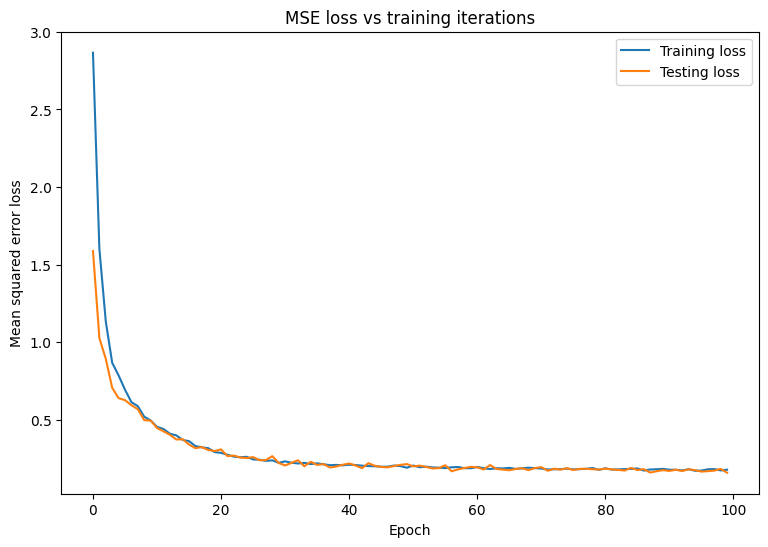

In [13]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations");

In [14]:
class ExportModule(tf.Module):
    def __init__(self, model, extract_features, norm_x, norm_y):
    # Initialize pre and postprocessing functions
        self.model = model
        self.extract_features = extract_features
        self.norm_x = norm_x
        self.norm_y = norm_y

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)]) 
    def __call__(self, x):
    # Run the ExportModule for new data points
        x = self.extract_features(x)
        x = self.norm_x.norm(x)
        y = self.model(x)
        y = self.norm_y.unnorm(y)
        return y

In [15]:
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=onehot_origin,
                              norm_x=norm_x,
                              norm_y=norm_y)

In [16]:
import tempfile
import os

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: /var/folders/vm/4d22p22d2xn2spd1hbvqv2tm0000gn/T/tmpenlj7vh3/lin_reg_export/assets


In [17]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(x_test)
test_preds[:10].numpy()

2023-02-08 12:38:01.782007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([28.097498 , 26.193336 , 33.564373 , 27.719315 , 31.787924 ,
       24.014559 , 24.421043 , 13.4595785, 28.562454 , 27.368694 ],
      dtype=float32)